In [1]:
import jiwer
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
sns.set_theme(rc={"figure.figsize":(12, 9)}, font_scale=1.5)

from bert_score import BERTScorer

/home/vinicius/miniforge3/envs/nemo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_reference_transcripts(root_path: str):
    reference_transcripts = []
    for dir_path,_,filenames in os.walk(root_path):
        reference_transcripts.extend(map(
            lambda name: os.path.join(dir_path, name),
            filter(lambda name: re.match(r'.*\.txt', name), filenames)
            ))
    return reference_transcripts

In [3]:
text_clean_reference_transcript_files = get_reference_transcripts('./audio/LibriSpeech/test-clean/')
text_clean_reference_transcript_files, len(text_clean_reference_transcript_files)

(['./audio/LibriSpeech/test-clean/5142/36586/5142-36586.trans.txt',
  './audio/LibriSpeech/test-clean/5142/33396/5142-33396.trans.txt',
  './audio/LibriSpeech/test-clean/5142/36377/5142-36377.trans.txt',
  './audio/LibriSpeech/test-clean/5142/36600/5142-36600.trans.txt',
  './audio/LibriSpeech/test-clean/8463/294828/8463-294828.trans.txt',
  './audio/LibriSpeech/test-clean/8463/294825/8463-294825.trans.txt',
  './audio/LibriSpeech/test-clean/8463/287645/8463-287645.trans.txt',
  './audio/LibriSpeech/test-clean/3729/6852/3729-6852.trans.txt',
  './audio/LibriSpeech/test-clean/3575/170457/3575-170457.trans.txt',
  './audio/LibriSpeech/test-clean/260/123286/260-123286.trans.txt',
  './audio/LibriSpeech/test-clean/260/123440/260-123440.trans.txt',
  './audio/LibriSpeech/test-clean/260/123288/260-123288.trans.txt',
  './audio/LibriSpeech/test-clean/1089/134691/1089-134691.trans.txt',
  './audio/LibriSpeech/test-clean/1089/134686/1089-134686.trans.txt',
  './audio/LibriSpeech/test-clean/6829

In [4]:
text_other_reference_transcript_files = get_reference_transcripts('./audio/LibriSpeech/test-other/')
text_other_reference_transcript_files, len(text_other_reference_transcript_files)

(['./audio/LibriSpeech/test-other/3331/159605/3331-159605.trans.txt',
  './audio/LibriSpeech/test-other/3331/159609/3331-159609.trans.txt',
  './audio/LibriSpeech/test-other/2033/164915/2033-164915.trans.txt',
  './audio/LibriSpeech/test-other/2033/164914/2033-164914.trans.txt',
  './audio/LibriSpeech/test-other/2033/164916/2033-164916.trans.txt',
  './audio/LibriSpeech/test-other/5442/41169/5442-41169.trans.txt',
  './audio/LibriSpeech/test-other/5442/41168/5442-41168.trans.txt',
  './audio/LibriSpeech/test-other/5442/32873/5442-32873.trans.txt',
  './audio/LibriSpeech/test-other/1998/29454/1998-29454.trans.txt',
  './audio/LibriSpeech/test-other/1998/29455/1998-29455.trans.txt',
  './audio/LibriSpeech/test-other/1998/15444/1998-15444.trans.txt',
  './audio/LibriSpeech/test-other/3764/168670/3764-168670.trans.txt',
  './audio/LibriSpeech/test-other/3764/168671/3764-168671.trans.txt',
  './audio/LibriSpeech/test-other/4198/61336/4198-61336.trans.txt',
  './audio/LibriSpeech/test-other/

In [5]:
def extract_individual_quartznet_transcripts(file_path: str) -> dict:
    transcripts_dict = {}
    with open(file_path, 'r') as f:
        for line in f.readlines():
            file_name, transcript = line.split(' , ')
            file_name = file_name.split('/')[-1].replace('_transformed', '')
            transcripts_dict[file_name] = {'generated': transcript.strip()}
    return transcripts_dict

clean_transcripts_quartznet_base = extract_individual_quartznet_transcripts('./transcripts/test-clean-quartznet-base-transcript.txt')
clean_transcripts_quartznet_LS = extract_individual_quartznet_transcripts('./transcripts/test-clean-quartznet-LS-transcript.txt')
clean_transcripts_quartznet_NR = extract_individual_quartznet_transcripts('./transcripts/test-clean-quartznet-NR-transcript.txt')

other_transcripts_quartznet_base = extract_individual_quartznet_transcripts('./transcripts/test-other-quartznet-base-transcript.txt')
other_transcripts_quartznet_LS = extract_individual_quartznet_transcripts('./transcripts/test-other-quartznet-LS-transcript.txt')
other_transcripts_quartznet_NR = extract_individual_quartznet_transcripts('./transcripts/test-other-quartznet-NR-transcript.txt')

In [6]:
def add_reference_transcripts(transcript_dict: dict, reference_files: list) -> dict:
    for reference_transcript_file in reference_files:
        with open(reference_transcript_file, 'r') as f:
            for line in f.readlines():
                file_name, transcript = re.match(r'(?P<file_name>\d+(-\d+)+) (?P<transcript>.*)', line).groupdict().values()
                try:
                    transcript_dict[file_name]['reference'] = transcript.lower()
                except KeyError:
                    continue
    return transcript_dict

clean_transcripts_quartznet_base = add_reference_transcripts(clean_transcripts_quartznet_base, text_clean_reference_transcript_files)
clean_transcripts_quartznet_LS = add_reference_transcripts(clean_transcripts_quartznet_LS, text_clean_reference_transcript_files)
clean_transcripts_quartznet_NR = add_reference_transcripts(clean_transcripts_quartznet_NR, text_clean_reference_transcript_files)

other_transcripts_quartznet_base = add_reference_transcripts(other_transcripts_quartznet_base, text_other_reference_transcript_files)
other_transcripts_quartznet_LS = add_reference_transcripts(other_transcripts_quartznet_LS, text_other_reference_transcript_files)
other_transcripts_quartznet_NR = add_reference_transcripts(other_transcripts_quartznet_NR, text_other_reference_transcript_files)

In [7]:
def calculate_word_accuracy(transcripts_dict: dict) -> float:
    return 1 - jiwer.wer(
        reference=list(map(lambda item: item[1]['reference'], transcripts_dict.items())),
        hypothesis=list(map(lambda item: item[1]['generated'], transcripts_dict.items()))
        )

wa_clean_quartznet_base = calculate_word_accuracy(clean_transcripts_quartznet_base)
wa_clean_quartznet_LS = calculate_word_accuracy(clean_transcripts_quartznet_LS)
wa_clean_quartznet_NR = calculate_word_accuracy(clean_transcripts_quartznet_NR)

wa_other_quartznet_base = calculate_word_accuracy(other_transcripts_quartznet_base)
wa_other_quartznet_LS = calculate_word_accuracy(other_transcripts_quartznet_LS)
wa_other_quartznet_NR = calculate_word_accuracy(other_transcripts_quartznet_NR)

print(f'Word accuracy for QuartzNet_base on test-clean: {wa_clean_quartznet_base}')
print(f'Word accuracy for QuartzNet_LS on test-clean: {wa_clean_quartznet_LS}')
print(f'Word accuracy for QuartzNet_NR on test-clean: {wa_clean_quartznet_NR}')

print(f'Word accuracy for QuartzNet_base on test-other: {wa_other_quartznet_base}')
print(f'Word accuracy for QuartzNet_LS on test-other: {wa_other_quartznet_LS}')
print(f'Word accuracy for QuartzNet_NR on test-other: {wa_other_quartznet_NR}')

Word accuracy for QuartzNet_base on test-clean: 0.8777605047780166
Word accuracy for QuartzNet_LS on test-clean: 0.8302089524941704
Word accuracy for QuartzNet_NR on test-clean: 0.8724566777925107
Word accuracy for QuartzNet_base on test-other: 0.6863108744981672
Word accuracy for QuartzNet_LS on test-other: 0.58068598359225
Word accuracy for QuartzNet_NR on test-other: 0.6806161633792983


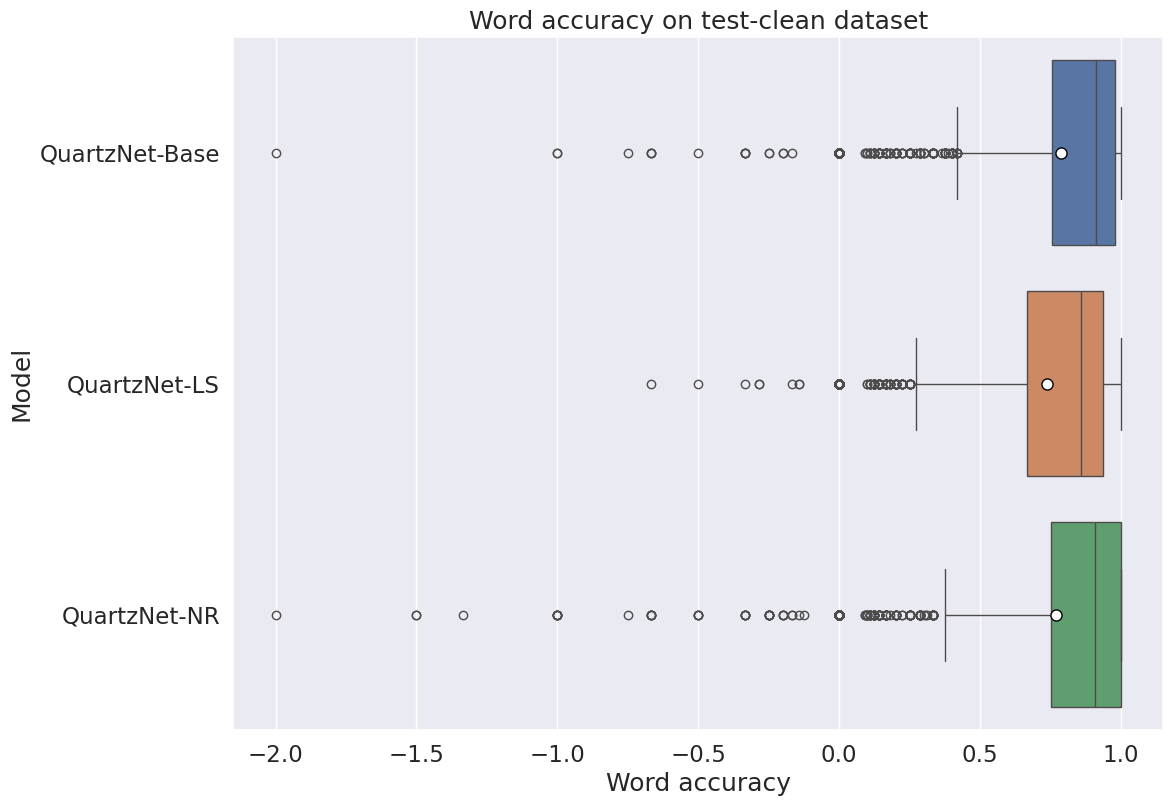

In [8]:
wa_dict_clean = {'QuartzNet-Base': [], 'QuartzNet-LS': [], 'QuartzNet-NR': []}

for transcript_base, transcript_LS, transcript_NR in zip(
    clean_transcripts_quartznet_base.items(), 
    clean_transcripts_quartznet_LS.items(),
    clean_transcripts_quartznet_NR.items()):
    wa_dict_clean['QuartzNet-Base'].append(1 - jiwer.wer(transcript_base[1]['reference'], transcript_base[1]['generated']))
    wa_dict_clean['QuartzNet-LS'].append(1 - jiwer.wer(transcript_LS[1]['reference'], transcript_LS[1]['generated']))
    wa_dict_clean['QuartzNet-NR'].append(1 - jiwer.wer(transcript_NR[1]['reference'], transcript_NR[1]['generated']))

df = pd.DataFrame(wa_dict_clean)
ax = sns.boxplot(df, orient='y', showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
ax.set_xlabel('Word accuracy')
ax.set_ylabel('Model')
plt.title('Word accuracy on test-clean dataset')
plt.show()

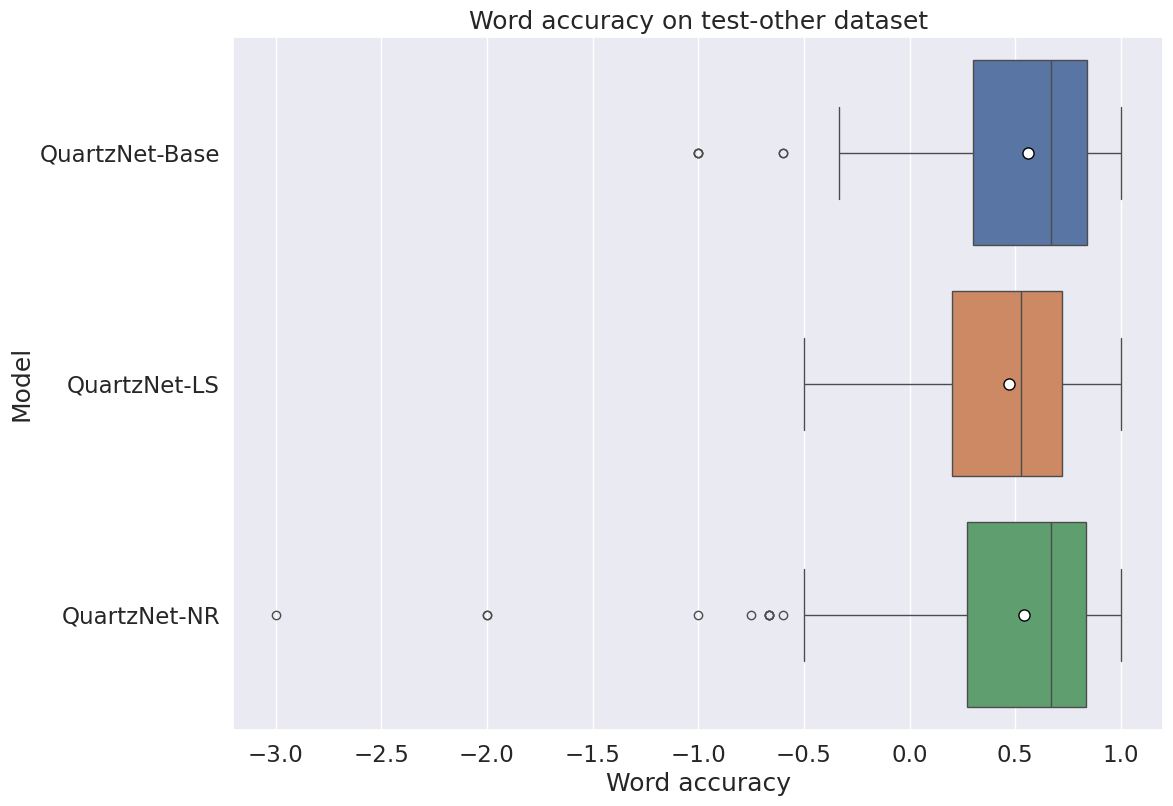

In [9]:
wa_dict_other = {'QuartzNet-Base': [], 'QuartzNet-LS': [], 'QuartzNet-NR': []}

for transcript_base, transcript_LS, transcript_NR in zip(
    other_transcripts_quartznet_base.items(), 
    other_transcripts_quartznet_LS.items(),
    other_transcripts_quartznet_NR.items()):
    wa_dict_other['QuartzNet-Base'].append(1 - jiwer.wer(transcript_base[1]['reference'], transcript_base[1]['generated']))
    wa_dict_other['QuartzNet-LS'].append(1 - jiwer.wer(transcript_LS[1]['reference'], transcript_LS[1]['generated']))
    wa_dict_other['QuartzNet-NR'].append(1 - jiwer.wer(transcript_NR[1]['reference'], transcript_NR[1]['generated']))

df = pd.DataFrame(wa_dict_other)
ax = sns.boxplot(df, orient='y', showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
ax.set_xlabel('Word accuracy')
ax.set_ylabel('Model')
plt.title('Word accuracy on test-other dataset')
plt.show()

In [10]:
def calculate_fbert_score(transcripts: dict, idf = False):
    if idf:
        print('Using idf weighing')
        idf_sents = list(map(lambda v: v['reference'],transcripts.values()))
        scorer = BERTScorer(lang='en', idf=idf, idf_sents=idf_sents, rescale_with_baseline=True)
    else:
        scorer = BERTScorer(lang='en', idf=idf, rescale_with_baseline=True)
    *_, f1 = scorer.score(
        cands=list(map(lambda item: item[1]['generated'], transcripts.items())),
        refs=list(map(lambda item: item[1]['reference'], transcripts.items()))
        )
    return f1

fbert_clean_quartznet_base = calculate_fbert_score(clean_transcripts_quartznet_base)
fbert_clean_quartznet_LS = calculate_fbert_score(clean_transcripts_quartznet_LS)
fbert_clean_quartznet_NR = calculate_fbert_score(clean_transcripts_quartznet_NR)

fbert_other_quartznet_base = calculate_fbert_score(other_transcripts_quartznet_base)
fbert_other_quartznet_LS = calculate_fbert_score(other_transcripts_quartznet_LS)
fbert_other_quartznet_NR = calculate_fbert_score(other_transcripts_quartznet_NR)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

In [11]:
print(fbert_clean_quartznet_base.mean())
print(fbert_clean_quartznet_LS.mean())
print(fbert_clean_quartznet_NR.mean())

print(fbert_other_quartznet_base.mean())
print(fbert_other_quartznet_LS.mean())
print(fbert_other_quartznet_NR.mean())

tensor(0.6730)
tensor(0.5688)
tensor(0.6845)
tensor(0.3183)
tensor(0.1839)
tensor(0.3576)


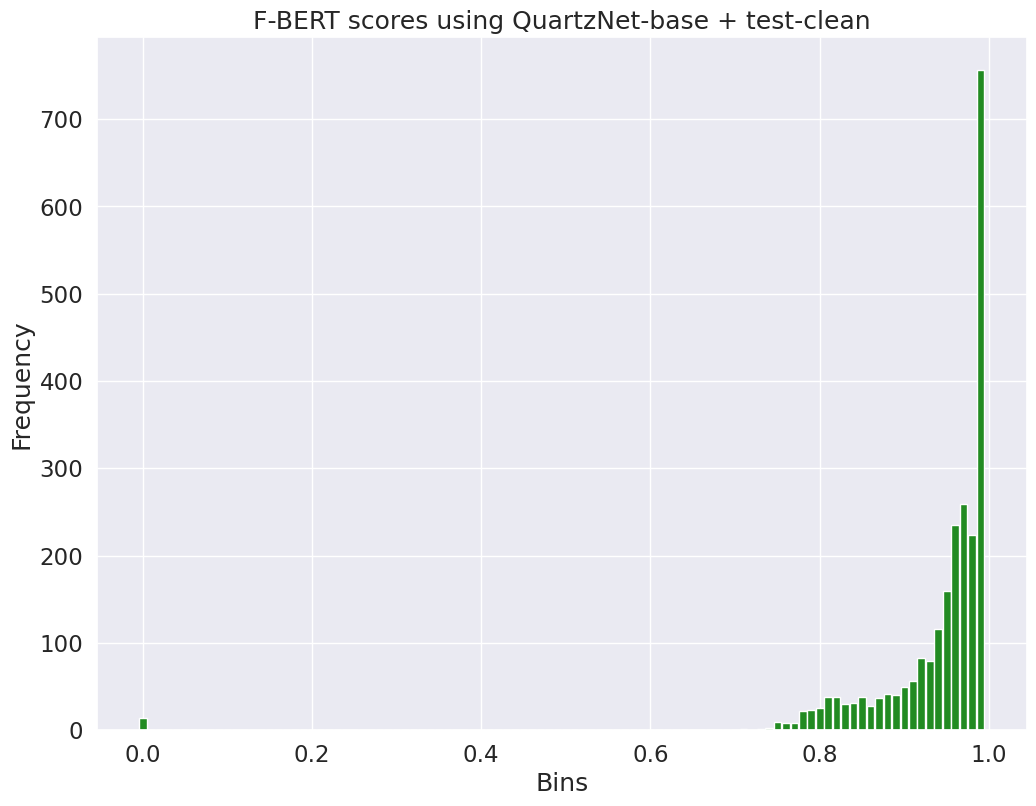

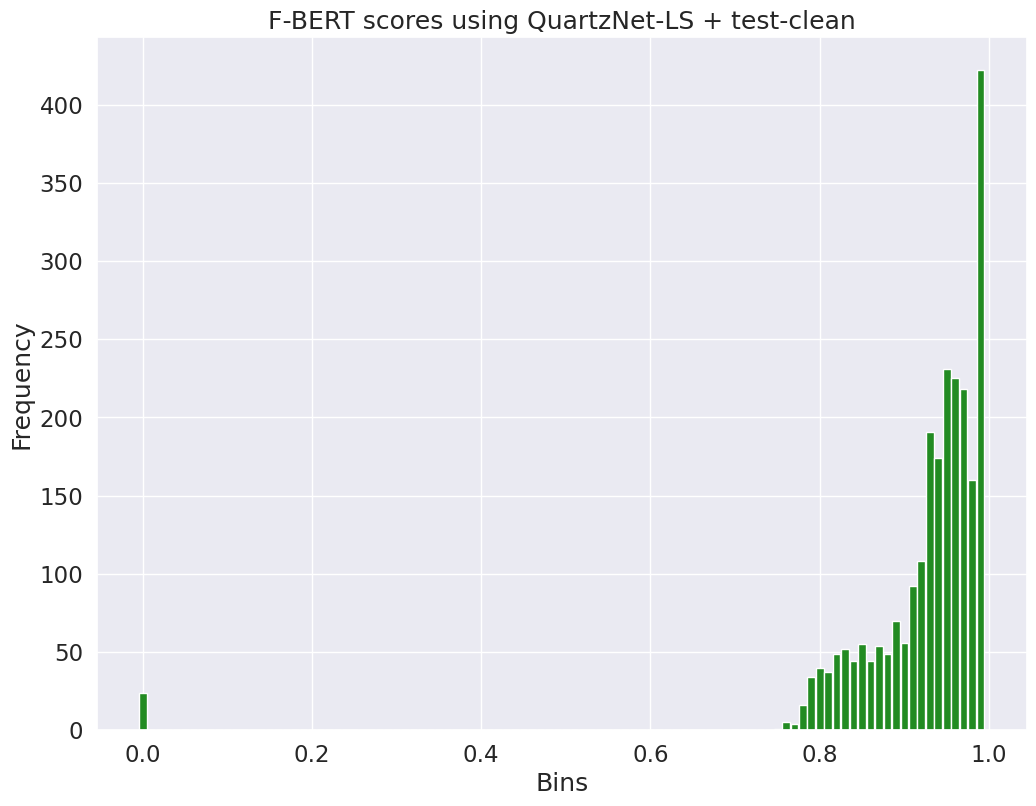

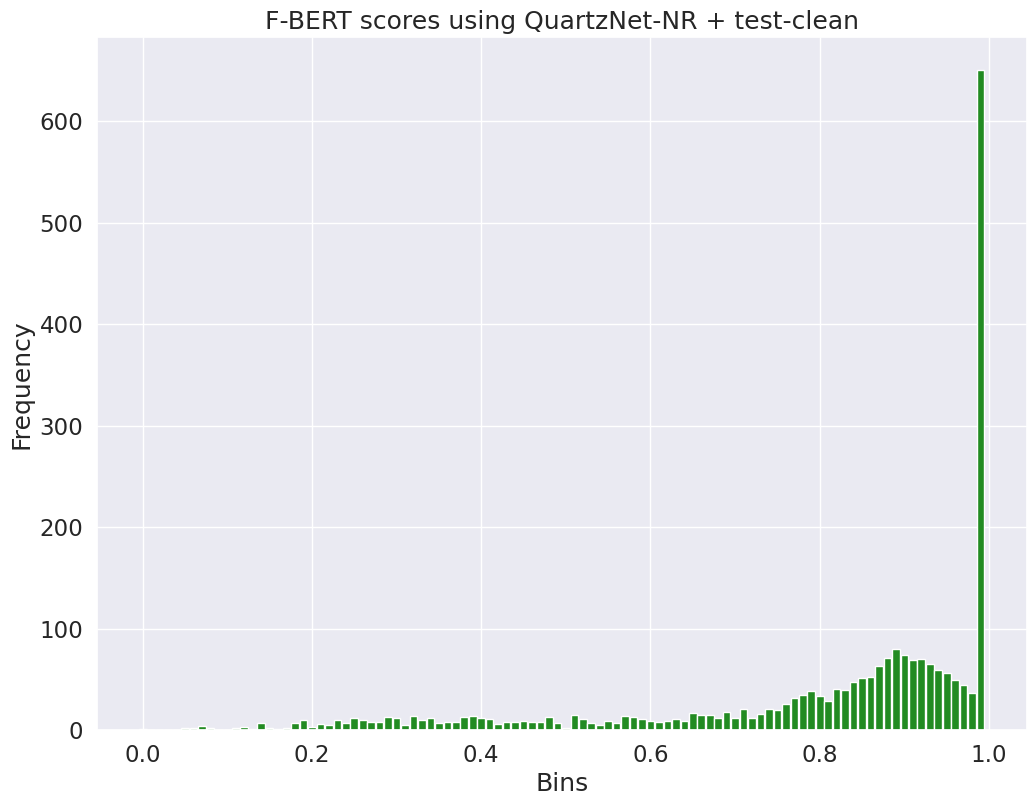

In [38]:
def plot_fbert_score_hist(fbert_scores, title):
    plt.bar(np.arange(0,1,0.01), fbert_scores.histc(), width=0.009, color=['forestgreen']) 
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_fbert_score_hist(fbert_clean_quartznet_base, 'F-BERT scores using QuartzNet-base + test-clean')
plot_fbert_score_hist(fbert_clean_quartznet_LS, 'F-BERT scores using QuartzNet-LS + test-clean')
plot_fbert_score_hist(fbert_clean_quartznet_NR, 'F-BERT scores using QuartzNet-NR + test-clean')

In [22]:
fbert_idf_clean_quartznet_base = calculate_fbert_score(clean_transcripts_quartznet_base, idf=True)
fbert_idf_clean_quartznet_LS = calculate_fbert_score(clean_transcripts_quartznet_LS, idf=True)
fbert_idf_clean_quartznet_NR = calculate_fbert_score(clean_transcripts_quartznet_NR, idf=True)

fbert_idf_other_quartznet_base = calculate_fbert_score(other_transcripts_quartznet_base, idf=True)
fbert_idf_other_quartznet_LS = calculate_fbert_score(other_transcripts_quartznet_LS, idf=True)
fbert_idf_other_quartznet_NR = calculate_fbert_score(other_transcripts_quartznet_NR, idf=True)

Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using idf weighing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print(fbert_idf_clean_quartznet_base.mean())
print(fbert_idf_clean_quartznet_LS.mean())
print(fbert_idf_clean_quartznet_NR.mean())

print(fbert_idf_other_quartznet_base.mean())
print(fbert_idf_other_quartznet_LS.mean())
print(fbert_idf_other_quartznet_NR.mean())

tensor(0.6431)
tensor(0.5288)
tensor(0.6562)
tensor(0.2618)
tensor(0.1143)
tensor(0.3019)


In [24]:
def plot_fbert_score_violin(fbert_scores: pd.DataFrame, title:str):
    ax = sns.boxplot(fbert_scores, orient='y', showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
    ax.set_xlabel('F-BERT score')
    ax.set_ylabel('Model')
    plt.title(title)
    plt.show()

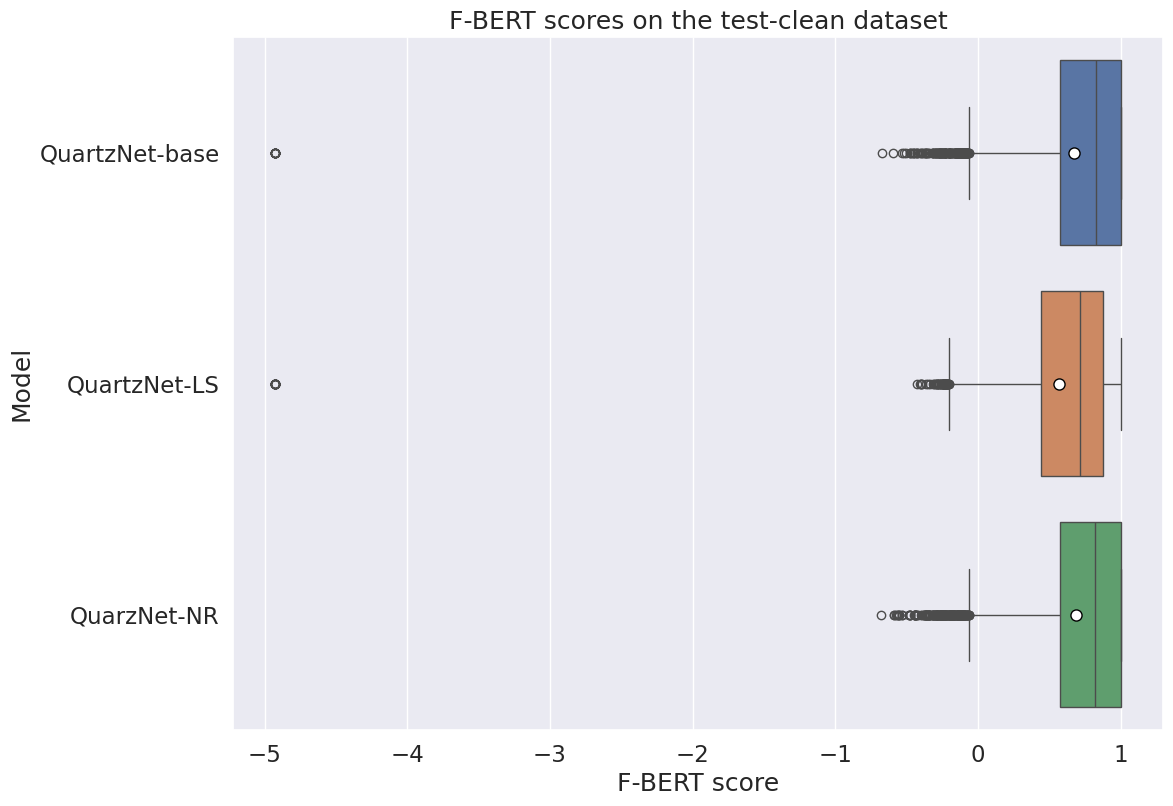

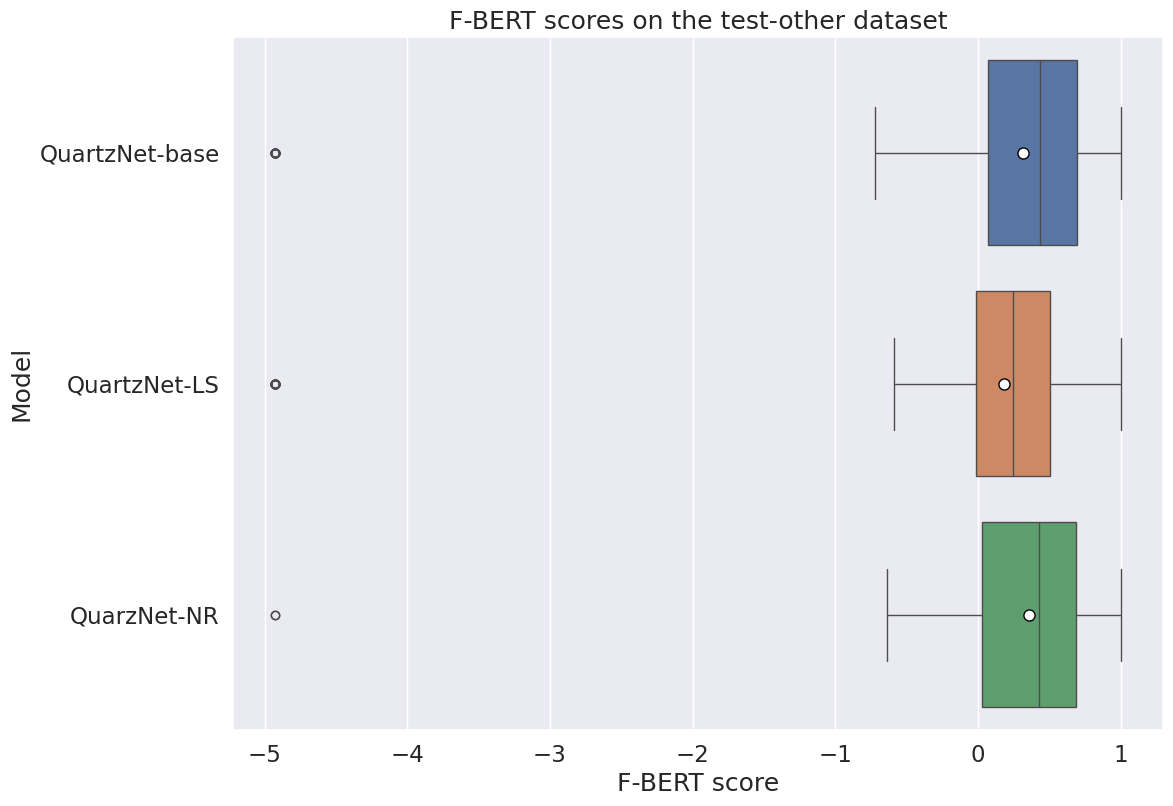

In [25]:
plot_fbert_score_violin(pd.DataFrame({
    'QuartzNet-base':fbert_clean_quartznet_base,
    'QuartzNet-LS':fbert_clean_quartznet_LS,
    'QuarzNet-NR': fbert_clean_quartznet_NR},
    dtype=np.float64), title='F-BERT scores on the test-clean dataset'
    )
plot_fbert_score_violin(pd.DataFrame({
    'QuartzNet-base':fbert_other_quartznet_base,
    'QuartzNet-LS':fbert_other_quartznet_LS,
    'QuarzNet-NR': fbert_other_quartznet_NR},
    dtype=np.float64), title='F-BERT scores on the test-other dataset'
    )

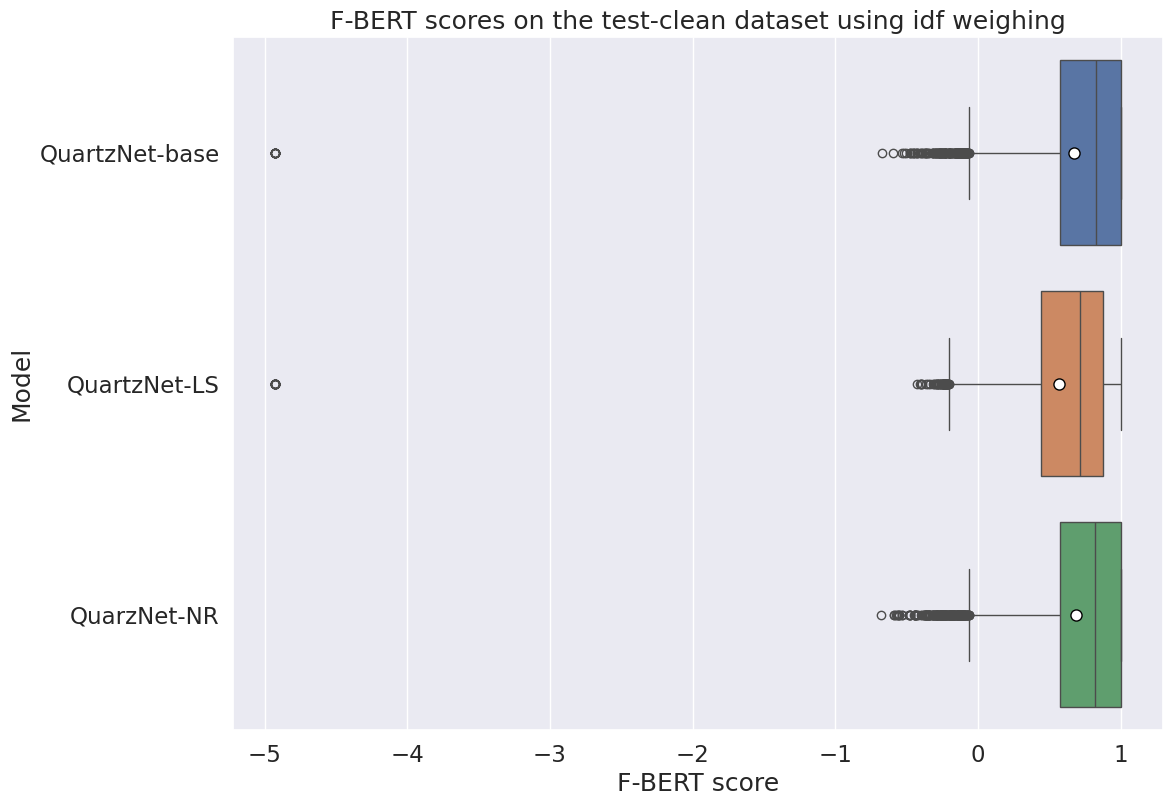

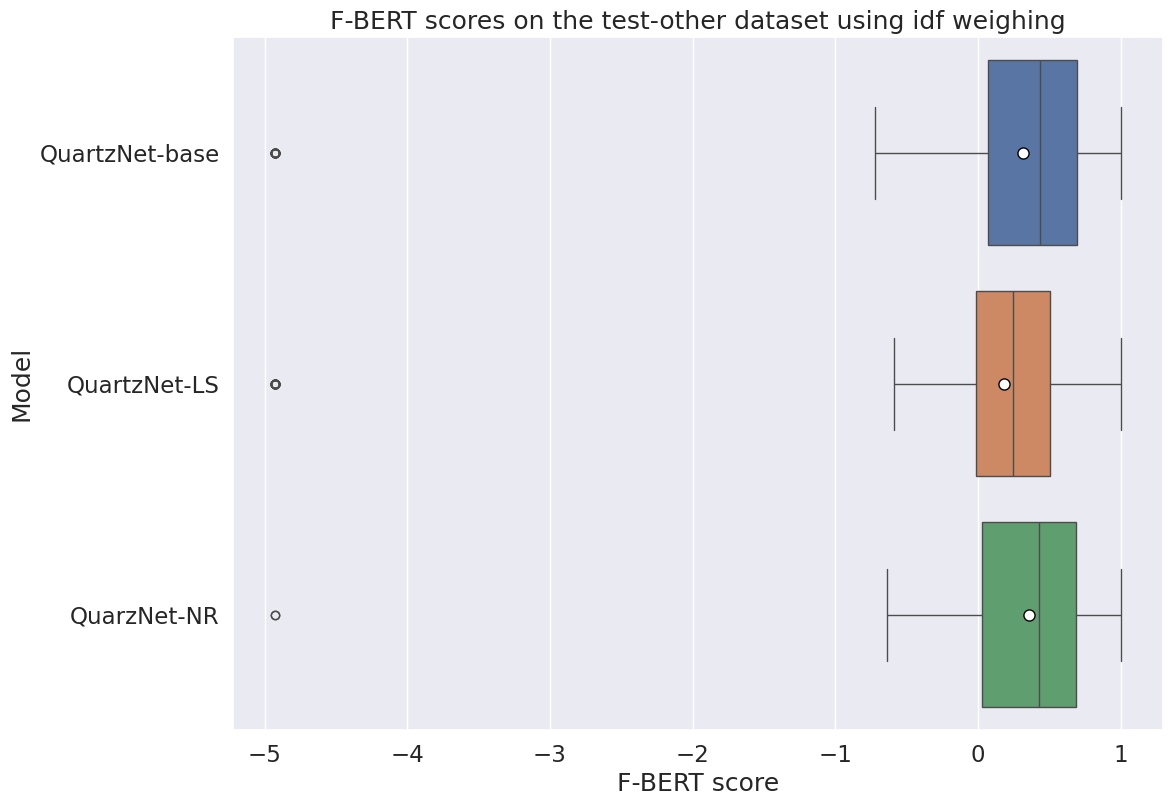

In [17]:
plot_fbert_score_violin(pd.DataFrame({
    'QuartzNet-base':fbert_idf_clean_quartznet_base,
    'QuartzNet-LS':fbert_idf_clean_quartznet_LS,
    'QuarzNet-NR': fbert_idf_clean_quartznet_NR},
    dtype=np.float64), title='F-BERT scores on the test-clean dataset using idf weighing'
    )
plot_fbert_score_violin(pd.DataFrame({
    'QuartzNet-base':fbert_idf_other_quartznet_base,
    'QuartzNet-LS':fbert_idf_other_quartznet_LS,
    'QuarzNet-NR': fbert_idf_other_quartznet_NR},
    dtype=np.float64), title='F-BERT scores on the test-other dataset using idf weighing'
    )

Although F-BERT scores are quite high, it might be due to sentences with nonsense transcripts still being considered 'similar' to the original transcripts. Investigate this with a few examples

In [18]:
def calculate_f1_bert_for_single_transcript(cand: str, ref: str) -> float:
    print([ref])
    scorer = BERTScorer(lang='en', rescale_with_baseline=True)
    p,r,f1 = scorer.score([cand], [ref])
    return f1[0]

In [19]:
bad_examples = [
    ('maholl lane alexander because he was imagined the euor', 'MAINHALL LIKED ALEXANDER BECAUSE HE WAS AN ENGINEER'.lower()),
    ('bot a hevor afour shouted graam there is no stingy coward', 'BY THE HAMMER OF THOR SHOUTED GRIM HERE IS NO STINGY COWARD'.lower()),
    ('i ocur o the sier', 'BARTLEY BENT LOWER OVER THE FIRE'.lower()),
    ('o', 'IT WAS WRITTEN IN LATIN'.lower())
]

bad_f1_scores = []

for cand, ref in bad_examples:
    bad_f1_scores.append(calculate_f1_bert_for_single_transcript(cand, ref))

['mainhall liked alexander because he was an engineer']


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['by the hammer of thor shouted grim here is no stingy coward']


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['bartley bent lower over the fire']


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['it was written in latin']


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
bad_f1_scores

[tensor(0.3246), tensor(0.3003), tensor(-0.0850), tensor(0.0392)]

In [44]:
calculate_f1_bert_for_single_transcript('then he toss the down and ceased the next', 'then he tossed it down and seized the next')

['then he tossed it down and seized the next']


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(0.4916)

In [45]:
1-jiwer.wer('then he tossed it down and seized the next', 'then he toss the down and ceased the next')

0.6666666666666667